In [ ]:
# Imports & basic settings
import os, random, json, pickle, re, itertools, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, precision_recall_fscore_support,
                             accuracy_score, confusion_matrix, precision_recall_curve, auc)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout, LSTM, Bidirectional,
                                     concatenate, Lambda, Multiply)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
warnings.filterwarnings("ignore")
plt.style.use('default')

# Path to dataset on Kaggle
KAGGLE_DATA_PATH = '/kaggle/input/legalclausedataset'

# Hyperparameters (tweak if needed)
RANDOM_SEED = 42
MAX_VOCAB = 40000
EMBED_DIM = 128
MAX_LEN = 120
BATCH_SIZE = 64
EPOCHS = 12

# Reproducibility
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



In [2]:
# Utilities & robust AttentionVector implementation
from tensorflow.keras.layers import Dense as KDense, Softmax

class AttentionVector(Layer):
    """
    Convert (batch, time, features) -> (batch, features) using learnable per-time scores.
    Stable and ensures the time dimension is reduced.
    """
    def __init__(self, use_score_dense=True, **kwargs):
        super(AttentionVector, self).__init__(**kwargs)
        self.use_score_dense = use_score_dense

    def build(self, input_shape):
        feat_dim = int(input_shape[-1])
        if self.use_score_dense:
            # project each time-step to a score
            self.score_dense = KDense(1, use_bias=False)
        else:
            self.W = self.add_weight(name='att_w', shape=(feat_dim,), initializer='random_normal', trainable=True)
        super(AttentionVector, self).build(input_shape)

    def call(self, x, mask=None):
        # x: (batch, time, features)
        if self.use_score_dense:
            scores = self.score_dense(x)             # (batch, time, 1)
            scores = K.squeeze(scores, axis=-1)     # (batch, time)
        else:
            scores = K.dot(K.tanh(x), K.expand_dims(self.W))
            scores = K.squeeze(scores, axis=-1)
        weights = K.softmax(scores, axis=1)         # (batch, time)
        weights = K.expand_dims(weights, axis=-1)   # (batch, time, 1)
        weighted = x * weights                      # (batch, time, features)
        output = K.sum(weighted, axis=1)            # (batch, features)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

def clean_text(s):
    s = str(s).strip().replace('\n',' ')
    s = re.sub(r'\s+',' ', s).lower()
    s = re.sub(r'[^a-z0-9\s\.,;:\(\)\-\/&%]', ' ', s)
    s = re.sub(r'\s+',' ', s).strip()
    return s

def show_model_summary(model):
    model.summary()


In [4]:
# Pipeline class with fixed attention builder (display-first; optional saving)
class ClauseSimilarityPipelineDisplayFixed:
    def __init__(self, data_path, max_vocab=MAX_VOCAB, embed_dim=EMBED_DIM, max_len=MAX_LEN,
                 batch_size=BATCH_SIZE, epochs=EPOCHS, seed=RANDOM_SEED, save_artifacts=False, output_dir="/kaggle/working/artifacts_fixed"):
        self.data_path = Path(data_path)
        self.max_vocab = max_vocab
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.tokenizer = None
        self.save_artifacts = save_artifacts
        self.output_dir = Path(output_dir)
        if save_artifacts:
            self.output_dir.mkdir(parents=True, exist_ok=True)
        random.seed(self.seed); np.random.seed(self.seed); tf.random.set_seed(self.seed)
        self.metadata = {}

    # Load & clean dataset
    def load_all_csv(self):
        files = list(self.data_path.glob("*.csv"))
        if not files:
            raise FileNotFoundError(f"No CSV files found in {self.data_path}")
        df_list = []
        for f in files:
            temp = pd.read_csv(f)
            cols = temp.columns.tolist()
            if 'clause' in cols: temp = temp.rename(columns={'clause':'text'})
            elif 'Clause' in cols: temp = temp.rename(columns={'Clause':'text'})
            if 'clause_type' in cols: temp = temp.rename(columns={'clause_type':'type'})
            elif 'label' in cols and 'type' not in cols: temp = temp.rename(columns={'label':'type'})
            if 'text' in temp.columns and 'type' in temp.columns:
                df_list.append(temp[['text','type']].dropna())
            else:
                str_cols = [c for c in temp.columns if temp[c].dtype == object]
                if len(str_cols) >= 1:
                    df_list.append(temp[[str_cols[0]]].rename(columns={str_cols[0]:'text'}).assign(type=f.stem))
                else:
                    print("Skipping file (unknown schema):", f.name)
        self.df = pd.concat(df_list, ignore_index=True)
        self.df['text'] = self.df['text'].astype(str).apply(clean_text)
        self.df = self.df[self.df['text'].str.len() > 5].reset_index(drop=True)
        print("=== Dataset loaded ===")
        print("Files read:", len(files))
        print("Total clauses:", len(self.df))
        display(self.df.head(6))

    # Create balanced pairs
    def create_pairs(self, pos_limit_per_type=200, balance=True):
        from collections import defaultdict
        type_to_indices = defaultdict(list)
        for i,row in self.df.iterrows():
            type_to_indices[row['type']].append(i)
        pos_pairs, neg_pairs = [], []
        for t, idxs in type_to_indices.items():
            if len(idxs) < 2: continue
            pairs = list(itertools.combinations(idxs, 2))
            if len(pairs) > pos_limit_per_type:
                pairs = random.sample(pairs, pos_limit_per_type)
            pos_pairs.extend([(i,j,1) for i,j in pairs])
        all_idx = list(self.df.index)
        if balance:
            while len(neg_pairs) < len(pos_pairs):
                i,j = random.sample(all_idx,2)
                if self.df.loc[i,'type'] != self.df.loc[j,'type']:
                    neg_pairs.append((i,j,0))
        else:
            while len(neg_pairs) < max(len(pos_pairs), 2*len(pos_pairs)):
                i,j = random.sample(all_idx,2)
                if self.df.loc[i,'type'] != self.df.loc[j,'type']:
                    neg_pairs.append((i,j,0))
        pairs = pos_pairs + neg_pairs
        random.shuffle(pairs)
        pairs_df = pd.DataFrame(pairs, columns=['i','j','label'])
        pairs_df['text_a'] = pairs_df['i'].apply(lambda x: self.df.loc[x,'text'])
        pairs_df['text_b'] = pairs_df['j'].apply(lambda x: self.df.loc[x,'text'])
        self.pairs_df = pairs_df[['text_a','text_b','label']].reset_index(drop=True)
        print("Pairs created:", len(self.pairs_df), "| Pos:", len(pos_pairs), "Neg:", len(neg_pairs))
        display(self.pairs_df.head(6))

    # Tokenize & create padded sequences + splits; ensure labels 1D
    def prepare_tokenizer_and_sequences(self):
        texts = pd.concat([self.pairs_df['text_a'], self.pairs_df['text_b']])
        self.tokenizer = Tokenizer(num_words=self.max_vocab, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(texts.tolist())
        self.vocab_size = min(self.max_vocab, len(self.tokenizer.word_index) + 1)
        def to_padded(series):
            seq = self.tokenizer.texts_to_sequences(series.tolist())
            return pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        train_df, test_df = train_test_split(self.pairs_df, test_size=0.15, random_state=self.seed, stratify=self.pairs_df['label'])
        train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=self.seed, stratify=train_df['label'])
        self.X1_train, self.X2_train, self.y_train = to_padded(train_df['text_a']), to_padded(train_df['text_b']), train_df['label'].values
        self.X1_val, self.X2_val, self.y_val = to_padded(val_df['text_a']), to_padded(val_df['text_b']), val_df['label'].values
        self.X1_test, self.X2_test, self.y_test = to_padded(test_df['text_a']), to_padded(test_df['text_b']), test_df['label'].values
        # Ensure labels are 1D arrays
        self.y_train = self.y_train.reshape(-1)
        self.y_val = self.y_val.reshape(-1)
        self.y_test = self.y_test.reshape(-1)
        self.train_df, self.val_df, self.test_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)
        self.metadata.update({
            "vocab_size": int(self.vocab_size),
            "max_len": int(self.max_len),
            "embed_dim": int(self.embed_dim),
            "batch_size": int(self.batch_size),
            "epochs": int(self.epochs),
            "num_train_pairs": int(len(self.X1_train)),
            "num_val_pairs": int(len(self.X1_val)),
            "num_test_pairs": int(len(self.X1_test))
        })
        print("Tokenizer prepared — Vocab size:", self.vocab_size)
        # debug: print shapes
        print("Shapes -> X1_train:", self.X1_train.shape, "X2_train:", self.X2_train.shape, "y_train:", self.y_train.shape)

    # Shared encoder for siamese
    def create_shared_bilstm_encoder(self, lstm_units=128):
        inp = Input(shape=(self.max_len,), dtype='int32')
        x = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, input_length=self.max_len)(inp)
        x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
        x = Dense(128, activation='relu')(x)
        encoder = Model(inputs=inp, outputs=x, name='siamese_encoder')
        return encoder

    # Siamese BiLSTM
    def build_siamese_bilstm(self, lstm_units=128):
        encoder = self.create_shared_bilstm_encoder(lstm_units=lstm_units)
        ia, ib = Input(shape=(self.max_len,)), Input(shape=(self.max_len,))
        fa, fb = encoder(ia), encoder(ib)
        abs_diff = Lambda(lambda x: K.abs(x[0]-x[1]))([fa, fb])
        mult = Multiply()([fa, fb])
        merged = concatenate([fa, fb, abs_diff, mult])
        x = Dense(256, activation='relu')(merged); x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        out = Dense(1, activation='sigmoid')(x)   # (batch,1)
        model = Model([ia,ib], out, name='siamese_bilstm')
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Fixed BiLSTM + Attention using AttentionVector
    def build_bilstm_attention_fixed(self, lstm_units=128):
        ia, ib = Input(shape=(self.max_len,)), Input(shape=(self.max_len,))
        embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, input_length=self.max_len, name="embed")
        xa = embedding(ia)
        xa = Bidirectional(LSTM(lstm_units, return_sequences=True), name="bilstm_a")(xa)
        va = AttentionVector(name="attn_a")(xa)     # -> (batch, features)
        xb = embedding(ib)
        xb = Bidirectional(LSTM(lstm_units, return_sequences=True), name="bilstm_b")(xb)
        vb = AttentionVector(name="attn_b")(xb)     # -> (batch, features)
        diff = Lambda(lambda x: K.abs(x[0]-x[1]))([va, vb])
        mult = Multiply()([va, vb])
        merged = concatenate([va, vb, diff, mult])
        x = Dense(256, activation='relu')(merged); x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        out = Dense(1, activation='sigmoid')(x)   # (batch,1)
        model = Model([ia, ib], out, name='bilstm_attention_fixed')
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Train & display routine
    def train_and_display(self, model, model_name, patience=3, save_checkpoint=False):
        print(f"\n--- Training {model_name} ---")
        show_model_summary(model)
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
        if save_checkpoint and self.save_artifacts:
            ckpt = str(self.output_dir / f"{model_name}.h5")
            callbacks.append(ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0))
            print("Checkpoint will be saved to:", ckpt)
        history = model.fit([self.X1_train, self.X2_train], self.y_train,
                            validation_data=([self.X1_val, self.X2_val], self.y_val),
                            epochs=self.epochs, batch_size=self.batch_size, callbacks=callbacks, verbose=1)
        self._plot_history(history, model_name)
        return model, history

    # Evaluate & display metrics, confusion matrix, PR curve, and examples
    def evaluate_and_display(self, model, model_name, show_examples=5):
        print(f"\n=== Evaluation: {model_name} ===")
        y_prob = model.predict([self.X1_test, self.X2_test], batch_size=256).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        acc = accuracy_score(self.y_test, y_pred)
        prec, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='binary', zero_division=0)
        try:
            roc = roc_auc_score(self.y_test, y_prob)
        except:
            roc = float('nan')
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\n")
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred, digits=4))
        cm = confusion_matrix(self.y_test, y_pred)
        self._display_confusion(cm, model_name)
        self._display_pr_curve(self.y_test, y_prob, model_name)
        examples_df = pd.DataFrame({
            'text_a': self.test_df['text_a'].values,
            'text_b': self.test_df['text_b'].values,
            'label': self.y_test,
            'pred': y_pred,
            'prob': y_prob
        })
        print(f"\nSample CORRECT examples ({min(show_examples, len(examples_df[examples_df['label']==examples_df['pred']]))}):")
        display(examples_df[examples_df['label']==examples_df['pred']].sample(n=min(show_examples, len(examples_df[examples_df['label']==examples_df['pred']])), random_state=self.seed)[['text_a','text_b','label','prob']])
        print(f"\nSample INCORRECT examples ({min(show_examples, len(examples_df[examples_df['label']!=examples_df['pred']]))}):")
        display(examples_df[examples_df['label']!=examples_df['pred']].sample(n=min(show_examples, len(examples_df[examples_df['label']!=examples_df['pred']])), random_state=self.seed)[['text_a','text_b','label','prob']])
        self.metadata[f"{model_name}_metrics"] = {"accuracy":acc, "precision":prec, "recall":recall, "f1":f1, "roc_auc":roc}
        return y_prob, y_pred

    # Plot helpers
    def _plot_history(self, history, name):
        fig, axes = plt.subplots(1,2, figsize=(14,4))
        axes[0].plot(history.history.get('loss',[]), label='train_loss')
        axes[0].plot(history.history.get('val_loss',[]), label='val_loss')
        axes[0].legend(); axes[0].set_title(f"{name} Loss")
        axes[1].plot(history.history.get('accuracy',[]), label='train_acc')
        axes[1].plot(history.history.get('val_accuracy',[]), label='val_acc')
        axes[1].legend(); axes[1].set_title(f"{name} Accuracy")
        plt.show()

    def _display_confusion(self, cm, name):
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f"{name} Confusion Matrix"); tick_marks = np.arange(2)
        ax.set_xticks(tick_marks); ax.set_yticks(tick_marks)
        ax.set_xticklabels(['Not-Sim','Sim']); ax.set_yticklabels(['Not-Sim','Sim'])
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
        plt.show()

    def _display_pr_curve(self, y_true, y_prob, name):
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title(f'{name} PR Curve')
        ax.legend(); plt.show()

    # Optional saving
    def save_artifacts_if_requested(self, trained_models_dict):
        if not self.save_artifacts:
            print("save_artifacts is False — skipping saves.")
            return
        with open(self.output_dir / "tokenizer.pkl", 'wb') as f: pickle.dump(self.tokenizer, f)
        with open(self.output_dir / "metadata.json", 'w') as f: json.dump(self.metadata, f, indent=2)
        for name, model in trained_models_dict.items():
            path = self.output_dir / f"{name}.h5"
            model.save(path)
            print("Saved model:", path)


In [6]:
# Pipeline class with fixed attention builder (display-first; optional saving)
class ClauseSimilarityPipelineDisplayFixed:
    def __init__(self, data_path, max_vocab=MAX_VOCAB, embed_dim=EMBED_DIM, max_len=MAX_LEN,
                 batch_size=BATCH_SIZE, epochs=EPOCHS, seed=RANDOM_SEED, save_artifacts=False, output_dir="/kaggle/working/artifacts_fixed"):
        self.data_path = Path(data_path)
        self.max_vocab = max_vocab
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.tokenizer = None
        self.save_artifacts = save_artifacts
        self.output_dir = Path(output_dir)
        if save_artifacts:
            self.output_dir.mkdir(parents=True, exist_ok=True)
        random.seed(self.seed); np.random.seed(self.seed); tf.random.set_seed(self.seed)
        self.metadata = {}

    # Load & clean dataset
    def load_all_csv(self):
        files = list(self.data_path.glob("*.csv"))
        if not files:
            raise FileNotFoundError(f"No CSV files found in {self.data_path}")
        df_list = []
        for f in files:
            temp = pd.read_csv(f)
            cols = temp.columns.tolist()
            if 'clause' in cols: temp = temp.rename(columns={'clause':'text'})
            elif 'Clause' in cols: temp = temp.rename(columns={'Clause':'text'})
            if 'clause_type' in cols: temp = temp.rename(columns={'clause_type':'type'})
            elif 'label' in cols and 'type' not in cols: temp = temp.rename(columns={'label':'type'})
            if 'text' in temp.columns and 'type' in temp.columns:
                df_list.append(temp[['text','type']].dropna())
            else:
                str_cols = [c for c in temp.columns if temp[c].dtype == object]
                if len(str_cols) >= 1:
                    df_list.append(temp[[str_cols[0]]].rename(columns={str_cols[0]:'text'}).assign(type=f.stem))
                else:
                    print("Skipping file (unknown schema):", f.name)
        self.df = pd.concat(df_list, ignore_index=True)
        self.df['text'] = self.df['text'].astype(str).apply(clean_text)
        self.df = self.df[self.df['text'].str.len() > 5].reset_index(drop=True)
        print("=== Dataset loaded ===")
        print("Files read:", len(files))
        print("Total clauses:", len(self.df))
        display(self.df.head(6))

    # Create balanced pairs
    def create_pairs(self, pos_limit_per_type=200, balance=True):
        from collections import defaultdict
        type_to_indices = defaultdict(list)
        for i,row in self.df.iterrows():
            type_to_indices[row['type']].append(i)
        pos_pairs, neg_pairs = [], []
        for t, idxs in type_to_indices.items():
            if len(idxs) < 2: continue
            pairs = list(itertools.combinations(idxs, 2))
            if len(pairs) > pos_limit_per_type:
                pairs = random.sample(pairs, pos_limit_per_type)
            pos_pairs.extend([(i,j,1) for i,j in pairs])
        all_idx = list(self.df.index)
        if balance:
            while len(neg_pairs) < len(pos_pairs):
                i,j = random.sample(all_idx,2)
                if self.df.loc[i,'type'] != self.df.loc[j,'type']:
                    neg_pairs.append((i,j,0))
        else:
            while len(neg_pairs) < max(len(pos_pairs), 2*len(pos_pairs)):
                i,j = random.sample(all_idx,2)
                if self.df.loc[i,'type'] != self.df.loc[j,'type']:
                    neg_pairs.append((i,j,0))
        pairs = pos_pairs + neg_pairs
        random.shuffle(pairs)
        pairs_df = pd.DataFrame(pairs, columns=['i','j','label'])
        pairs_df['text_a'] = pairs_df['i'].apply(lambda x: self.df.loc[x,'text'])
        pairs_df['text_b'] = pairs_df['j'].apply(lambda x: self.df.loc[x,'text'])
        self.pairs_df = pairs_df[['text_a','text_b','label']].reset_index(drop=True)
        print("Pairs created:", len(self.pairs_df), "| Pos:", len(pos_pairs), "Neg:", len(neg_pairs))
        display(self.pairs_df.head(6))

    # Tokenize & create padded sequences + splits; ensure labels 1D
    def prepare_tokenizer_and_sequences(self):
        texts = pd.concat([self.pairs_df['text_a'], self.pairs_df['text_b']])
        self.tokenizer = Tokenizer(num_words=self.max_vocab, oov_token="<OOV>")
        self.tokenizer.fit_on_texts(texts.tolist())
        self.vocab_size = min(self.max_vocab, len(self.tokenizer.word_index) + 1)
        def to_padded(series):
            seq = self.tokenizer.texts_to_sequences(series.tolist())
            return pad_sequences(seq, maxlen=self.max_len, padding='post', truncating='post')
        train_df, test_df = train_test_split(self.pairs_df, test_size=0.15, random_state=self.seed, stratify=self.pairs_df['label'])
        train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=self.seed, stratify=train_df['label'])
        self.X1_train, self.X2_train, self.y_train = to_padded(train_df['text_a']), to_padded(train_df['text_b']), train_df['label'].values
        self.X1_val, self.X2_val, self.y_val = to_padded(val_df['text_a']), to_padded(val_df['text_b']), val_df['label'].values
        self.X1_test, self.X2_test, self.y_test = to_padded(test_df['text_a']), to_padded(test_df['text_b']), test_df['label'].values
        # Ensure labels are 1D arrays
        self.y_train = self.y_train.reshape(-1)
        self.y_val = self.y_val.reshape(-1)
        self.y_test = self.y_test.reshape(-1)
        self.train_df, self.val_df, self.test_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)
        self.metadata.update({
            "vocab_size": int(self.vocab_size),
            "max_len": int(self.max_len),
            "embed_dim": int(self.embed_dim),
            "batch_size": int(self.batch_size),
            "epochs": int(self.epochs),
            "num_train_pairs": int(len(self.X1_train)),
            "num_val_pairs": int(len(self.X1_val)),
            "num_test_pairs": int(len(self.X1_test))
        })
        print("Tokenizer prepared — Vocab size:", self.vocab_size)
        # debug: print shapes
        print("Shapes -> X1_train:", self.X1_train.shape, "X2_train:", self.X2_train.shape, "y_train:", self.y_train.shape)

    # Shared encoder for siamese
    def create_shared_bilstm_encoder(self, lstm_units=128):
        inp = Input(shape=(self.max_len,), dtype='int32')
        x = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, input_length=self.max_len)(inp)
        x = Bidirectional(LSTM(lstm_units, return_sequences=False))(x)
        x = Dense(128, activation='relu')(x)
        encoder = Model(inputs=inp, outputs=x, name='siamese_encoder')
        return encoder

    # Siamese BiLSTM
    def build_siamese_bilstm(self, lstm_units=128):
        encoder = self.create_shared_bilstm_encoder(lstm_units=lstm_units)
        ia, ib = Input(shape=(self.max_len,)), Input(shape=(self.max_len,))
        fa, fb = encoder(ia), encoder(ib)
        abs_diff = Lambda(lambda x: K.abs(x[0]-x[1]))([fa, fb])
        mult = Multiply()([fa, fb])
        merged = concatenate([fa, fb, abs_diff, mult])
        x = Dense(256, activation='relu')(merged); x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        out = Dense(1, activation='sigmoid')(x)   # (batch,1)
        model = Model([ia,ib], out, name='siamese_bilstm')
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Fixed BiLSTM + Attention using AttentionVector
    def build_bilstm_attention_fixed(self, lstm_units=128):
        ia, ib = Input(shape=(self.max_len,)), Input(shape=(self.max_len,))
        embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embed_dim, input_length=self.max_len, name="embed")
        xa = embedding(ia)
        xa = Bidirectional(LSTM(lstm_units, return_sequences=True), name="bilstm_a")(xa)
        va = AttentionVector(name="attn_a")(xa)     # -> (batch, features)
        xb = embedding(ib)
        xb = Bidirectional(LSTM(lstm_units, return_sequences=True), name="bilstm_b")(xb)
        vb = AttentionVector(name="attn_b")(xb)     # -> (batch, features)
        diff = Lambda(lambda x: K.abs(x[0]-x[1]))([va, vb])
        mult = Multiply()([va, vb])
        merged = concatenate([va, vb, diff, mult])
        x = Dense(256, activation='relu')(merged); x = Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        out = Dense(1, activation='sigmoid')(x)   # (batch,1)
        model = Model([ia, ib], out, name='bilstm_attention_fixed')
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Train & display routine
    def train_and_display(self, model, model_name, patience=3, save_checkpoint=False):
        print(f"\n--- Training {model_name} ---")
        show_model_summary(model)
        callbacks = [EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)]
        if save_checkpoint and self.save_artifacts:
            ckpt = str(self.output_dir / f"{model_name}.h5")
            callbacks.append(ModelCheckpoint(ckpt, monitor='val_loss', save_best_only=True, verbose=0))
            print("Checkpoint will be saved to:", ckpt)
        history = model.fit([self.X1_train, self.X2_train], self.y_train,
                            validation_data=([self.X1_val, self.X2_val], self.y_val),
                            epochs=self.epochs, batch_size=self.batch_size, callbacks=callbacks, verbose=1)
        self._plot_history(history, model_name)
        return model, history

    # Evaluate & display metrics, confusion matrix, PR curve, and examples
    def evaluate_and_display(self, model, model_name, show_examples=5):
        print(f"\n=== Evaluation: {model_name} ===")
        y_prob = model.predict([self.X1_test, self.X2_test], batch_size=256).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        acc = accuracy_score(self.y_test, y_pred)
        prec, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred, average='binary', zero_division=0)
        try:
            roc = roc_auc_score(self.y_test, y_prob)
        except:
            roc = float('nan')
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}\n")
        print("Classification Report:")
        print(classification_report(self.y_test, y_pred, digits=4))
        cm = confusion_matrix(self.y_test, y_pred)
        self._display_confusion(cm, model_name)
        self._display_pr_curve(self.y_test, y_prob, model_name)
        examples_df = pd.DataFrame({
            'text_a': self.test_df['text_a'].values,
            'text_b': self.test_df['text_b'].values,
            'label': self.y_test,
            'pred': y_pred,
            'prob': y_prob
        })
        print(f"\nSample CORRECT examples ({min(show_examples, len(examples_df[examples_df['label']==examples_df['pred']]))}):")
        display(examples_df[examples_df['label']==examples_df['pred']].sample(n=min(show_examples, len(examples_df[examples_df['label']==examples_df['pred']])), random_state=self.seed)[['text_a','text_b','label','prob']])
        print(f"\nSample INCORRECT examples ({min(show_examples, len(examples_df[examples_df['label']!=examples_df['pred']]))}):")
        display(examples_df[examples_df['label']!=examples_df['pred']].sample(n=min(show_examples, len(examples_df[examples_df['label']!=examples_df['pred']])), random_state=self.seed)[['text_a','text_b','label','prob']])
        self.metadata[f"{model_name}_metrics"] = {"accuracy":acc, "precision":prec, "recall":recall, "f1":f1, "roc_auc":roc}
        return y_prob, y_pred

    # Plot helpers
    def _plot_history(self, history, name):
        fig, axes = plt.subplots(1,2, figsize=(14,4))
        axes[0].plot(history.history.get('loss',[]), label='train_loss')
        axes[0].plot(history.history.get('val_loss',[]), label='val_loss')
        axes[0].legend(); axes[0].set_title(f"{name} Loss")
        axes[1].plot(history.history.get('accuracy',[]), label='train_acc')
        axes[1].plot(history.history.get('val_accuracy',[]), label='val_acc')
        axes[1].legend(); axes[1].set_title(f"{name} Accuracy")
        plt.show()

    def _display_confusion(self, cm, name):
        fig, ax = plt.subplots(figsize=(4,4))
        ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f"{name} Confusion Matrix"); tick_marks = np.arange(2)
        ax.set_xticks(tick_marks); ax.set_yticks(tick_marks)
        ax.set_xticklabels(['Not-Sim','Sim']); ax.set_yticklabels(['Not-Sim','Sim'])
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], 'd'), ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
        plt.show()

    def _display_pr_curve(self, y_true, y_prob, name):
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = auc(recall, precision)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.4f})')
        ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title(f'{name} PR Curve')
        ax.legend(); plt.show()

    # Optional saving
    def save_artifacts_if_requested(self, trained_models_dict):
        if not self.save_artifacts:
            print("save_artifacts is False — skipping saves.")
            return
        with open(self.output_dir / "tokenizer.pkl", 'wb') as f: pickle.dump(self.tokenizer, f)
        with open(self.output_dir / "metadata.json", 'w') as f: json.dump(self.metadata, f, indent=2)
        for name, model in trained_models_dict.items():
            path = self.output_dir / f"{name}.h5"
            model.save(path)
            print("Saved model:", path)


=== Dataset loaded ===
Files read: 395
Total clauses: 150881


,text,type
0,certain definitions. for purposes of this agre...,certain-definitions
1,certain definitions. as used in this agreement...,certain-definitions
2,certain definitions. for purposes of this agre...,certain-definitions
3,certain definitions. for purposes of this agre...,certain-definitions
4,certain definitions. as used in this agreement...,certain-definitions
5,certain definitions. for purposes of this agre...,certain-definitions


Pairs created: 157810 | Pos: 78905 Neg: 78905


,text_a,text_b,label
0,attorneys fees. in the event of any dispute re...,attorneys fees. each of the parties shall pay ...,1
1,indemnification and contribution. (a) the comp...,indemnification and contribution. (a) the comp...,1
2,right of setoff. with respect to claims for lo...,right of setoff. collateral includes the bank ...,1
3,governing law. this agreement is to be constru...,conditions to effectiveness. this first amendm...,0
4,increased costs. if at any time a lender shall...,increased costs. (a) except with respect to ta...,1
5,notice of default. the borrowers will promptly...,notice of default. mezzanine borrower shall pr...,1


Tokenizer prepared — Vocab size: 40000
Shapes -> X1_train: (114017, 120) X2_train: (114017, 120) y_train: (114017,)


I0000 00:00:1762783942.871075      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- Training Siamese_BiLSTM ---


Model: "siamese_bilstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ siamese_encoder     │ (None, 128)       │  5,416,064 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ siamese_encoder[… │
│                     │                   │            │ siamese_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128)       │          0 │ siamese_encoder[… │
│                     │                   │            │ siamese_encoder[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ siamese_encoder[… │
│ (Concatenate)       │                   │            │ siamese_encoder[… │
│                     │                   │            │ lambda[0][0],     │
│                     │                   │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     16,448 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,563,905 (21.22 MB)

 Trainable params: 5,563,905 (21.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12


I0000 00:00:1762783948.997234     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


1782/1782 ━━━━━━━━━━━━━━━━━━━━ 76s 39ms/step - accuracy: 0.9282 - loss: 0.1305 - val_accuracy: 0.9988 - val_loss: 0.0058
Epoch 2/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 70s 39ms/step - accuracy: 0.9986 - loss: 0.0058 - val_accuracy: 0.9989 - val_loss: 0.0052
Epoch 3/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.9990 - loss: 0.0042 - val_accuracy: 0.9983 - val_loss: 0.0059
Epoch 4/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9994 - val_loss: 0.0022
Epoch 5/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 6/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 70s 39ms/step - accuracy: 0.9995 - loss: 0.0022 - val_accuracy: 0.9993 - val_loss: 0.0028
Epoch 7/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.9996 - loss: 0.0016 - val_accuracy: 0.9996 - val_loss: 0.0030


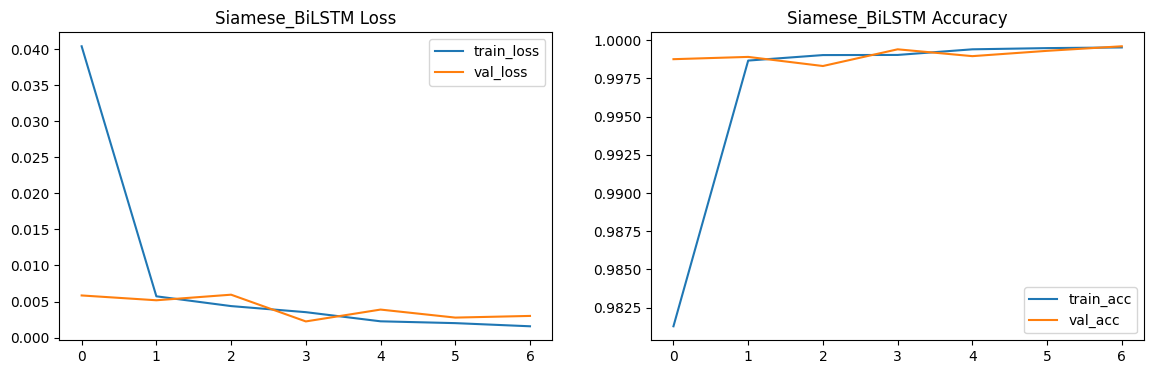


=== Evaluation: Siamese_BiLSTM ===
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Accuracy: 0.9992 | Precision: 0.9992 | Recall: 0.9992 | F1: 0.9992 | ROC-AUC: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9992    0.9992     11836
           1     0.9992    0.9992    0.9992     11836

    accuracy                         0.9992     23672
   macro avg     0.9992    0.9992    0.9992     23672
weighted avg     0.9992    0.9992    0.9992     23672



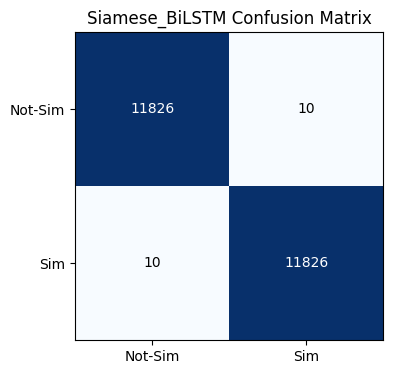

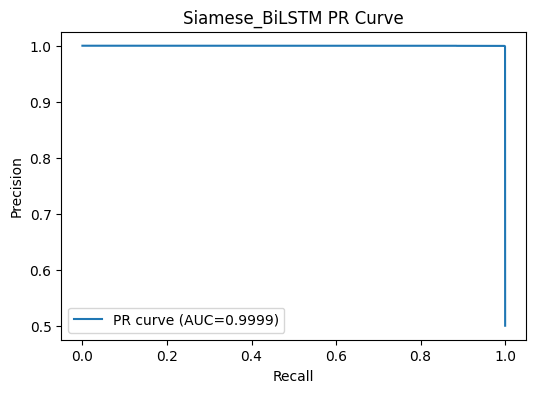


Sample CORRECT examples (5):


,text_a,text_b,label,prob
11400,ownership. ownership of the deposits during th...,ownership. except as set forth in the prelimin...,1,9.944621e-01
2057,no violation. neither the execution and delive...,costs. 23.6.1 each party shall bear that party...,0,1.683744e-21
18906,exceptions. 9.3.1 clause 9.1 (increased costs)...,delivery. any term of delivery specified is ti...,0,5.827297e-17
3356,maintenance of office or agency. the company a...,maintenance of office or agency. the issuing e...,1,1.000000e+00
11479,"liens. create, incur, assume or suffer to exis...","liens. create, incur, assume or suffer to exis...",1,9.999999e-01



Sample INCORRECT examples (5):


,text_a,text_b,label,prob
707,records. the records accurately reflect in all...,records of disciplinary actions involving redu...,1,0.307416
16454,notice of default. the company shall notify th...,notice of defaults. article vi the indenture t...,0,0.816286
15101,investments. directly or indirectly acquire or...,"investments. the borrower shall not, nor shall...",1,0.256694
1179,investments. directly or indirectly acquire or...,"investments. the borrower will not, and will n...",1,0.097153
5356,full disclosure. neither this agreement nor an...,reinstatement. if after receipt and applicatio...,0,0.708661



--- Training BiLSTM_Attention_Fixed ---


Model: "bilstm_attention_fixed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 120)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embed (Embedding)   │ (None, 120, 128)  │  5,120,000 │ input_layer_3[0]… │
│                     │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_a            │ (None, 120, 256)  │    263,168 │ embed[0][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm_b            │ (None, 120, 256)  │    263,168 │ embed[1][0]       │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_a              │ (None, 256)       │          0 │ bilstm_a[0][0]    │
│ (AttentionVector)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attn_b              │ (None, 256)       │          0 │ bilstm_b[0][0]    │
│ (AttentionVector)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ attn_a[0][0],     │
│                     │                   │            │ attn_b[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ attn_a[0][0],     │
│ (Multiply)          │                   │            │ attn_b[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1024)      │          0 │ attn_a[0][0],     │
│ (Concatenate)       │                   │            │ attn_b[0][0],     │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    262,400 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │     16,448 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,925,249 (22.60 MB)

 Trainable params: 5,925,249 (22.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 79s 42ms/step - accuracy: 0.7213 - loss: 0.4809 - val_accuracy: 0.8901 - val_loss: 0.2445
Epoch 2/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9440 - loss: 0.1453 - val_accuracy: 0.9942 - val_loss: 0.0216
Epoch 3/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 41ms/step - accuracy: 0.9954 - loss: 0.0191 - val_accuracy: 0.9970 - val_loss: 0.0135
Epoch 4/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9979 - loss: 0.0088 - val_accuracy: 0.9978 - val_loss: 0.0088
Epoch 5/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9985 - loss: 0.0063 - val_accuracy: 0.9974 - val_loss: 0.0154
Epoch 6/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9991 - loss: 0.0048 - val_accuracy: 0.9977 - val_loss: 0.0120
Epoch 7/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9986 - loss: 0.0053 - val_accuracy: 0.9982 - val_loss: 0.0073
Epoch 8/12
1782/1782 ━━━━━━━━━━━━━━━━━━━━ 74s 42ms/step - accuracy: 0.9993 -

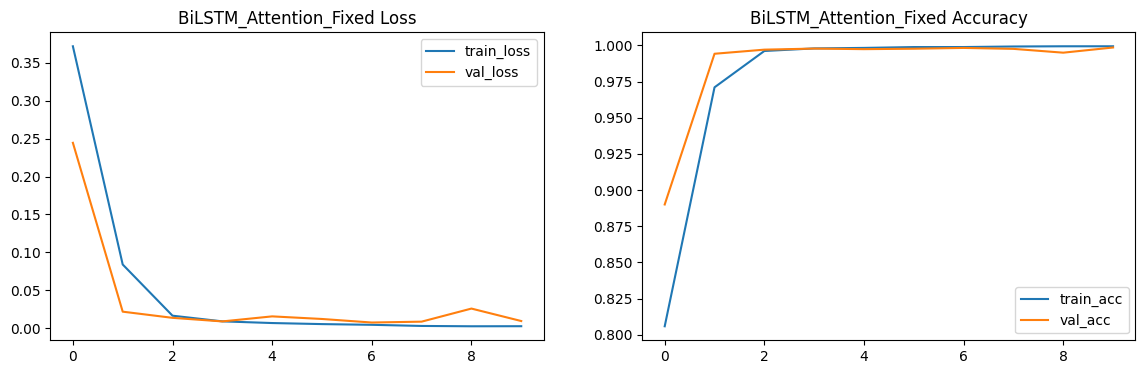


=== Evaluation: BiLSTM_Attention_Fixed ===
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Accuracy: 0.9978 | Precision: 0.9958 | Recall: 0.9998 | F1: 0.9978 | ROC-AUC: 0.9999

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9958    0.9978     11836
           1     0.9958    0.9998    0.9978     11836

    accuracy                         0.9978     23672
   macro avg     0.9978    0.9978    0.9978     23672
weighted avg     0.9978    0.9978    0.9978     23672



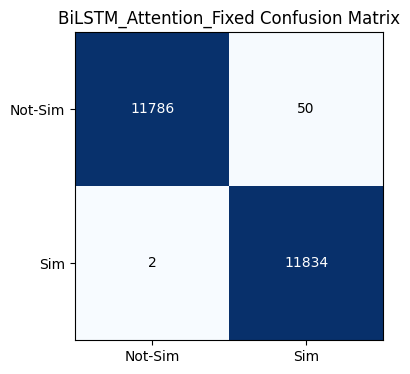

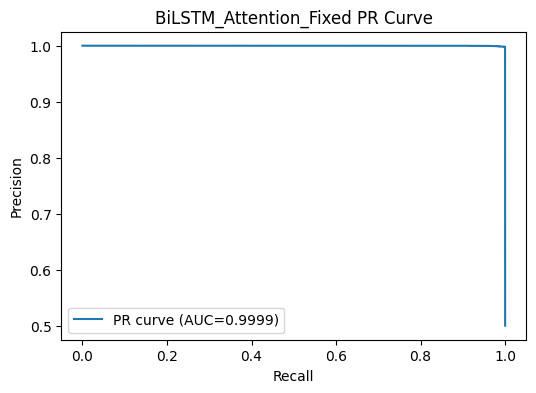


Sample CORRECT examples (5):


,text_a,text_b,label,prob
4963,subsidiaries. (a) the company has no direct or...,subsidiaries. the only subsidiaries of cbi are...,1,9.999994e-01
6161,set-off. (1) funds due from the company may be...,set-off. the authority will be entitled but no...,1,9.999999e-01
4145,authorization. except as may be limited by app...,delegation of duties. the administrator may de...,0,5.482110e-12
1493,intellectual property rights. client grants to...,intellectual property rights. member agrees to...,1,9.999999e-01
9241,security. mba undertakes no duty to exercise c...,security. to the extent requested by indemnite...,1,9.999999e-01



Sample INCORRECT examples (5):


,text_a,text_b,label,prob
10337,access to information. the participant has had...,access. the rights of ingress and egress herei...,0,0.999798
19195,environmental laws. (a) comply in all material...,dispute resolution. except for any proceeding ...,0,0.966945
21022,proprietary rights. the consultant agrees that...,arbitration. notwithstanding any provision of ...,0,0.999999
6961,payment a. the city will reimburse botg kitebo...,payment. 56.2.1 compensation for on-call servi...,1,0.440625
19810,"representations, warranties and covenants. the...",representations and warranties of seller. sell...,0,0.824389


In [7]:
# Run the pipeline (DISPLAY-FIRST; optional saving if save_artifacts=True)
pipeline = ClauseSimilarityPipelineDisplayFixed(
    data_path=KAGGLE_DATA_PATH,
    max_vocab=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    max_len=MAX_LEN,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    seed=RANDOM_SEED,
    save_artifacts=False  # set True if you want to save tokenizer/models/metadata
)

# 1) Load data
pipeline.load_all_csv()

# 2) Create balanced pairs
pipeline.create_pairs(pos_limit_per_type=200, balance=True)

# 3) Tokenize & prepare sequences
pipeline.prepare_tokenizer_and_sequences()

# 4) Build, train and display Siamese BiLSTM
siamese_model = pipeline.build_siamese_bilstm(lstm_units=128)
siamese_model, hist_siam = pipeline.train_and_display(siamese_model, "Siamese_BiLSTM", patience=3, save_checkpoint=False)

# 5) Evaluate Siamese
y_prob_siam, y_pred_siam = pipeline.evaluate_and_display(siamese_model, "Siamese_BiLSTM", show_examples=5)

# 6) Build, train and display BiLSTM + Attention (fixed)
att_model = pipeline.build_bilstm_attention_fixed(lstm_units=128)
att_model, hist_att = pipeline.train_and_display(att_model, "BiLSTM_Attention_Fixed", patience=3, save_checkpoint=False)

# 7) Evaluate Attention model
y_prob_att, y_pred_att = pipeline.evaluate_and_display(att_model, "BiLSTM_Attention_Fixed", show_examples=5)

# 8) Optionally save artifacts (set save_artifacts=True in constructor then call)
# pipeline.save_artifacts_if_requested({'Siamese_BiLSTM': siamese_model, 'BiLSTM_Attention_Fixed': att_model})


In [9]:
#  Quick summary / metadata print (for report)
print("=== Experiment metadata (partial) ===")
display(pipeline.metadata)
print("\n=== Example test pairs (first 6) ===")
display(pipeline.test_df.head(6))


=== Experiment metadata (partial) ===


{'vocab_size': 40000,
 'max_len': 120,
 'embed_dim': 128,
 'batch_size': 64,
 'epochs': 12,
 'num_train_pairs': 114017,
 'num_val_pairs': 20121,
 'num_test_pairs': 23672,
 'Siamese_BiLSTM_metrics': {'accuracy': 0.9991551199729638,
  'precision': 0.9991551199729638,
  'recall': 0.9991551199729638,
  'f1': 0.9991551199729638,
  'roc_auc': 0.9999273328939233},
 'BiLSTM_Attention_Fixed_metrics': {'accuracy': 0.997803311929706,
  'precision': 0.9957926624032313,
  'recall': 0.9998310239945928,
  'f1': 0.9978077571669477,
  'roc_auc': 0.9999112112181795}}


=== Example test pairs (first 6) ===


,text_a,text_b,label
0,non-competition. during the time of the employ...,dissolution. 24.1. a partner can give notice t...,0
1,independent contractor. the contractor is an i...,parties in interest. all the terms and provisi...,0
2,no waiver. no failure by the issuer or the tru...,"termination for cause. the company may, at its...",0
3,fees. the administrative agent shall have rece...,fees. in consideration of the performance of t...,1
4,whereas the company has registered or will reg...,whereas the manager desires to retain the sub-...,1
5,"defaults and remedies. under the indenture, ev...",defaults and remedies. section 6.01 events of ...,1


In [14]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_and_show_qualitative_clean(model, model_name, pipeline, show_examples=5, save_examples=False):
    X1_test, X2_test, y_true = pipeline.X1_test, pipeline.X2_test, pipeline.y_test
    y_prob = model.predict([X1_test, X2_test], batch_size=256).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    # metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except:
        roc = float('nan')

    print(f"\n=== Model: {model_name} — Summary Metrics ===")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC-AUC: {roc:.4f}")

    # build dataframe for analysis
    df = pd.DataFrame({
        'text_a': pipeline.test_df['text_a'].values,
        'text_b': pipeline.test_df['text_b'].values,
        'true': y_true,
        'pred': y_pred,
        'prob': y_prob
    })
    df['true_label_str'] = df['true'].map({1:'SIMILAR', 0:'DISSIMILAR'})
    df['pred_label_str'] = df['pred'].map({1:'SIMILAR', 0:'DISSIMILAR'})

    tp = df[(df['true']==1) & (df['pred']==1)]
    tn = df[(df['true']==0) & (df['pred']==0)]
    fp = df[(df['true']==0) & (df['pred']==1)]
    fn = df[(df['true']==1) & (df['pred']==0)]

    print(f"Counts -> TP: {len(tp)} | TN: {len(tn)} | FP: {len(fp)} | FN: {len(fn)}")
    print("\nv--- Qualitative Results ---\n")

    # Correct examples (mix TP and TN)
    print("Correctly Matched Examples (mix of TP/TN):")
    print("------------------------------")
    correct_samples = pd.concat([
        tp.sample(n=min(3,len(tp)), random_state=42) if len(tp)>0 else pd.DataFrame(),
        tn.sample(n=min(3,len(tn)), random_state=42) if len(tn)>0 else pd.DataFrame()
    ])
    if len(correct_samples)==0:
        print("No correct examples available in test split.")
    else:
        for _, row in correct_samples.iterrows():
            print(f"TRUE LABEL: {row['true_label_str']} (Predicted: {row['pred_label_str']})")
            print("Clause A:", row['text_a'])
            print("Clause B:", row['text_b'])
            print("------------------------------")

    # Incorrect examples
    print("\nIncorrectly Matched Examples:")
    print("------------------------------")
    # False Positives
    if len(fp)>0:
        print("\nFalse Positives (Predicted: SIMILAR but True: DISSIMILAR):")
        for _, row in fp.sort_values(by='prob', ascending=False).head(min(3, len(fp))).iterrows():
            print(f"Pred prob: {row['prob']:.4f} | TRUE LABEL: {row['true_label_str']} (Predicted: {row['pred_label_str']})")
            print("Clause A:", row['text_a'])
            print("Clause B:", row['text_b'])
            print("------------------------------")
    else:
        print("\nNo False Positives in test set (count=0).")

    # False Negatives
    if len(fn)>0:
        print("\nFalse Negatives (Predicted: DISSIMILAR but True: SIMILAR):")
        for _, row in fn.sort_values(by='prob', ascending=True).head(min(3, len(fn))).iterrows():
            print(f"Pred prob: {row['prob']:.4f} | TRUE LABEL: {row['true_label_str']} (Predicted: {row['pred_label_str']})")
            print("Clause A:", row['text_a'])
            print("Clause B:", row['text_b'])
            print("------------------------------")
    else:
        print("\nNo False Negatives in test set (count=0).")

    # optional saving
    if save_examples:
        fp.to_csv(f"{model_name}_false_positives.csv", index=False)
        fn.to_csv(f"{model_name}_false_negatives.csv", index=False)
        tp.to_csv(f"{model_name}_true_positives.csv", index=False)
        tn.to_csv(f"{model_name}_true_negatives.csv", index=False)
        print(f"\nSaved CSVs: {model_name}_false_positives.csv, {model_name}_false_negatives.csv, {model_name}_true_positives.csv, {model_name}_true_negatives.csv")

    return df

In [15]:

# For Siamese BiLSTM
# Run for the Siamese model if available
if 'siamese_model' in globals():
    df_siam = evaluate_and_show_qualitative_clean(siamese_model, "Siamese_BiLSTM", pipeline, show_examples=5, save_examples=False)

93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step

=== Model: Siamese_BiLSTM — Summary Metrics ===
Accuracy: 0.9992 | Precision: 0.9992 | Recall: 0.9992 | F1: 0.9992 | ROC-AUC: 0.9999
Counts -> TP: 11826 | TN: 11826 | FP: 10 | FN: 10

v--- Qualitative Results ---

Correctly Matched Examples (mix of TP/TN):
------------------------------
TRUE LABEL: SIMILAR (Predicted: SIMILAR)
Clause A: bonus. for fiscal each year of company, employee will be eligible to earn a bonus payment based on performance, determined in accordance with exhibit a (the bonus ). the bonus, if any, shall be paid to employee within two and one-half (2.5) months after the end of the applicable fiscal year.
Clause B: bonus. in addition to the equity grants provided for in section 5(b), the executive shall be eligible to receive a quarterly bonus in the form of a cash bonus and/or an equity grant of shares of the company s common stock (the bonus ) up to twelve thousand five hundred dollars ( 12,500) quarterly. executive s eligib

In [19]:
# For BiLSTM+Attention (fixed)

# Run for the Attention model if available (check variable name used)
if 'att_model' in globals():
    df_att = evaluate_and_show_qualitative_clean(att_model, "BiLSTM_Attention_Fixed", pipeline, show_examples=5, save_examples=False)
elif 'att_model_fixed' in globals():
    df_att = evaluate_and_show_qualitative_clean(att_model_fixed, "BiLSTM_Attention_Fixed", pipeline, show_examples=5, save_examples=False)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step

=== Model: BiLSTM_Attention_Fixed — Summary Metrics ===
Accuracy: 0.9978 | Precision: 0.9958 | Recall: 0.9998 | F1: 0.9978 | ROC-AUC: 0.9999
Counts -> TP: 11834 | TN: 11786 | FP: 50 | FN: 2

v--- Qualitative Results ---

Correctly Matched Examples (mix of TP/TN):
------------------------------
TRUE LABEL: SIMILAR (Predicted: SIMILAR)
Clause A: defined terms. terms section
Clause B: defined terms. indebtedness, loan documents and property jurisdiction and other capitalized terms used but not defined in this guaranty shall have the meanings assigned to them in the security instrument.
------------------------------
TRUE LABEL: SIMILAR (Predicted: SIMILAR)
Clause A: expenses. if requested by the seller, the company shall pay all reasonable out of pocket and documented costs and expenses associated with this agreement and the transactions contemplated by this agreement, including, but not limited to, the reasonable fees, disbursements and other char